# Fit all of the potential SNIa with `sncosmo`

Authors: Midori Rollins and Melissa Graham

For every DDF candidate listed in `potential_snia_list.txt`, use `sncosmo` to fit the lightcurve.

Write the fit results to the file `all_fit_snia_files/results_sncosmos.dat`.

Save the plots output by `sncosmo` in `all_fit_snia_files/all_fit_snia.pdf`.



## Set up and read in data

Import packages.

In [1]:
import sncosmo
import iminuit
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.backends.backend_pdf import PdfPages

Read in the nightly epoch lightcurves for all candidates.

In [2]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'

candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))

del fnm

Read in the list of candidate IDs for potential SNIa that Melissa made with the MLG_snia_menagerie.ipynb notebook.

In [3]:
potSNIa_candid = np.loadtxt('potential_snia_list.dat', dtype='str', usecols=(0))

In [4]:
# print(potSNIa_candid)

## Prepare arrays to hold fit results

Define arrays to hold their fit inputs and results.

The estimated redshift and the input boundaries, the fit results, and the peak magnitudes in B, g, r, and i

In [5]:
fit_est_z = np.zeros(len(potSNIa_candid), dtype='float')
fit_in_zlo = np.zeros(len(potSNIa_candid), dtype='float')
fit_in_zhi = np.zeros(len(potSNIa_candid), dtype='float')

fit_z   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ze  = np.zeros(len(potSNIa_candid), dtype='float') 
fit_t0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_t0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1e = np.zeros(len(potSNIa_candid), dtype='float')
fit_c   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ce  = np.zeros(len(potSNIa_candid), dtype='float')

fit_pmB = np.zeros(len(potSNIa_candid), dtype='float')
fit_pmg = np.zeros(len(potSNIa_candid), dtype='float')
fit_pmr = np.zeros(len(potSNIa_candid), dtype='float')
fit_pmi = np.zeros(len(potSNIa_candid), dtype='float')

### Skip candidates which cause `sncosmo` to fail

Some potential SNIa are just clearly not SNIa and `sncosmo` fails, and should be skipped during fitting.

In [6]:
skip_SNIa = np.asarray(['DC21bfph', 'DC21vfl', 'DC21kue', 'DC23jurva'], dtype='str')

## Run `sncosmo`

Define the  model for `sncosmo`.

In [7]:
model = sncosmo.Model(source='salt2')

Ignore runtime error "divide by zero encountered".

In [8]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Run `sncosmo` for each potential SNIa.

Put all the plots output by `sncosmo` into a single PDF "slide deck",
named `all_fit_snia_files/all_fit_snia.pdf`.

Any SNIa on the `skip_SNIa` list have their results set to default values of -99.9.

The only fit boundaries used are those of redshift. The lowest redshift that
`sncosmo` can accept is 0.05, so that is the lower limit on the lower boundary.
Use a range of 0.3 (+0.15 and -0.15 from the estimated redshift, which is based
on the minimum magnitude).

Use a zeropoint of 31.4 mag, the value to use with AB magnitudes and fluxes in nJy.

In [10]:
temp = []
pp = PdfPages('all_fit_snia_files/all_fit_snia.pdf')
zeropoint = 31.4

for c in range(len(potSNIa_candid)):
    
    temp.append(potSNIa_candid[c])
    
    sx = np.where(potSNIa_candid[c] == skip_SNIa)[0]
    if len(sx) == 0:

        # identify the lightcurve points for this candidate
        # do not include any lonely epochs
        tx = np.where((candLC_candid == potSNIa_candid[c]) & 
                      (candLC_lef == 0))[0]

        # get the minimum magnitude
        min_mag = np.min(candLC_mag[tx])

        # estimate the redshift based on minimum detected brightness
        #  z   = H0 * D_L / c
        #  mu  = 5.0 log(D_L) +25
        #  mu  = m - M = m + 19.3
        est_z = 70.0 * 10.0**(((min_mag + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

        # set the redshift boundaries
        zlo = est_z - 0.15
        zhi = est_z + 0.15
        if zlo < 0.05:
            diff = 0.05-zlo
            zlo = 0.05
            zhi += diff
            del diff
        
        fit_est_z[c] = est_z
        fit_in_zlo[c] = zlo
        fit_in_zhi[c] = zhi
        
        # write the lightcurve to a temporary file for sncosmo to read
        fout = open('temp_sncosmo.txt', 'w')
        fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
        for x in tx:
            if np.isfinite(candLC_mag[x]):
                flux = 10.0**((candLC_mag[x] - zeropoint)/(-2.5))
                fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - zeropoint)/(-2.5))
                fluxe = fluxhi - flux
                fout.write('%13.4f %5s %15.7f %14.7f %5.1f ab \n' % \
                           (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe, zeropoint))
        fout.close()

        # read the file with sncosmo
        data = sncosmo.read_lc('temp_sncosmo.txt')

        # do the fit
        result, fitted_model = sncosmo.fit_lc(data, model, ['z', 't0', 'x0', 'x1', 'c'], 
                                              bounds={'z':(zlo, zhi)})

        # store the results in the arrays
        fit_z[c]  = result['parameters'][0]
        fit_t0[c] = result['parameters'][1]
        fit_x0[c] = result['parameters'][2]
        fit_x1[c] = result['parameters'][3]
        fit_c[c]  = result['parameters'][4]
        fit_ze[c]  = result['errors']['z']
        fit_t0e[c] = result['errors']['t0']
        fit_x0e[c] = result['errors']['x0']
        fit_x1e[c] = result['errors']['x1']
        fit_ce[c]  = result['errors']['c']
        
        fit_pmB[c] = fitted_model.source_peakmag('bessellb', 'ab')
        fit_pmg[c] = fitted_model.source_peakmag('sdssg', 'ab')
        fit_pmr[c] = fitted_model.source_peakmag('sdssr', 'ab')
        fit_pmi[c] = fitted_model.source_peakmag('sdssi', 'ab')

        # add the sncosmos fit results plot to the PDF
        sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, 
                        model_label=potSNIa_candid[c], fname=pp, format='pdf')
        
        # clean up
        del min_mag, est_z
        del tx
        del data, result, fitted_model, zlo, zhi
        
    else:
        # set as default values to indicate no fit
        fit_z[c]  = -99.9
        fit_t0[c] = -99.9
        fit_x0[c] = -99.9
        fit_x1[c] = -99.9
        fit_c[c]  = -99.9
        fit_ze[c]  = -99.9
        fit_t0e[c] = -99.9
        fit_x0e[c] = -99.9
        fit_x1e[c] = -99.9
        fit_ce[c]  = -99.9
    
# convert list of candidate names to array
fit_cand = np.asarray(temp, dtype='str')
del temp

pp.close()

### Quick check of results

Show, as a quick check, the estimated redshift vs. the fit redshift (with the option to uncomment lines and plot the lower and upper boundaries on the fit redshift).

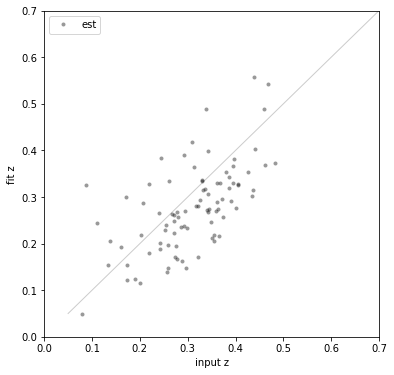

In [11]:
plt.figure(figsize=(6, 6))

tx = np.where(fit_z > -99.9)[0]

plt.plot([0.05, 0.7], [0.05, 0.7], ls='solid', lw=1, alpha=0.4, color='grey')
# plt.plot(fit_in_zlo[tx], fit_z[tx], 'o', ms=4, alpha=0.4, mew=0, color='blue', label='zlo')
plt.plot(fit_est_z[tx],  fit_z[tx], 'o', ms=4, alpha=0.4, mew=0, color='black', label='est')
# plt.plot(fit_in_zhi[tx], fit_z[tx], 'o', ms=4, alpha=0.4, mew=0, color='red', label='zhi')

plt.legend(loc='best')
plt.xlim([0.0,0.7])
plt.ylim([0.0,0.7])
plt.xlabel('input z')
plt.ylabel('fit z')
plt.show()

Compare the fitted magnitudes with the equation 
$m_{B} = −2.5\log(x_{0})+10.635$
(from <a href="https://arxiv.org/abs/1401.4065">Mosher et al. 2014</a>)

The SDSS g-band would be closest to the Bessel B-band, so green and black points should be similar.

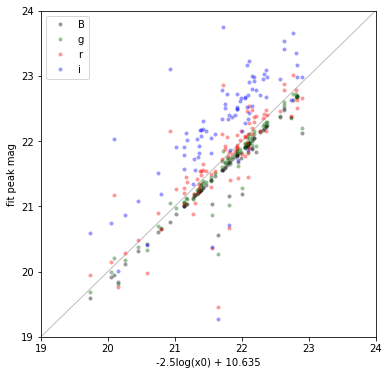

In [12]:
plt.figure(figsize=(6, 6))

tx = np.where(fit_z > -99.9)[0]

plt.plot([19.0, 24.0], [19.0, 24.0], ls='solid', alpha=0.5, lw=1, color='grey')
plt.plot(-2.5 * np.log10(fit_x0[tx]) + 10.635, fit_pmB[tx], 'o', ms=4, alpha=0.4, mew=0, 
         color='black', label='B')
plt.plot(-2.5 * np.log10(fit_x0[tx]) + 10.635, fit_pmg[tx], 'o', ms=4, alpha=0.4, mew=0, 
         color='darkgreen', label='g')
plt.plot(-2.5 * np.log10(fit_x0[tx]) + 10.635, fit_pmr[tx], 'o', ms=4, alpha=0.4, mew=0, 
         color='red', label='r')
plt.plot(-2.5 * np.log10(fit_x0[tx]) + 10.635, fit_pmi[tx], 'o', ms=4, alpha=0.4, mew=0, 
         color='blue', label='i')
plt.legend(loc='best')

plt.xlim([19.0, 24.0])
plt.ylim([19.0, 24.0])
plt.xlabel('-2.5log(x0) + 10.635')
plt.ylabel('fit peak mag')
plt.show()

The rest of the analysis will be done in subsequent notebooks.

### Write the fit results to a file

In [13]:
fnm = 'all_fit_snia_files/results_sncosmos.dat'
fout = open(fnm, 'w')

fout.write('# Melissa Graham & Midori Rollins, fit_potential_snia_sncosmos.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 id -- candidate identifier \n')
fout.write('#  1 estimated redshift \n')
fout.write('#  2 redshift lower boundry intput to fit \n')
fout.write('#  3 redshift upper boundry intput to fit \n')
fout.write('#  4 fit redshift \n')
fout.write('#  5 error in fit redshift \n')
fout.write('#  6 fit t0 \n')
fout.write('#  7 error in fit t0 \n')
fout.write('#  8 fit x0 \n')
fout.write('#  9 error in fit x0 \n')
fout.write('# 10 fit x1 \n')
fout.write('# 11 error in fit x1 \n')
fout.write('# 12 fit c \n')
fout.write('# 13 error in fit c \n')
fout.write('# 14 fit peak magnitude in bessel B \n')
fout.write('# 15 fit peak magnitude in sdss g \n')
fout.write('# 16 fit peak magnitude in sdss r \n')
fout.write('# 17 fit peak magnitude in sdss i \n')
fout.write('# \n')

for c in range(len(potSNIa_candid)):
    fout.write('%-14s %5.3f %5.3f %5.3f   '
               '%5.3f %5.3f %8.2f %5.2f '
               '%12.4E %12.4E %10.4f %10.4f '
               '%10.4f %10.4f '
               '%10.4f %10.4f %10.4f %10.4f \n' % \
               (fit_cand[c], fit_est_z[c], fit_in_zlo[c], fit_in_zhi[c], 
                fit_z[c], fit_ze[c], fit_t0[c], fit_t0e[c], 
                fit_x0[c], fit_x0e[c], fit_x1[c], fit_x1e[c], 
                fit_c[c], fit_ce[c], 
                fit_pmB[c], fit_pmg[c], fit_pmr[c], fit_pmi[c]) )
        
fout.close()
print('Wrote to: ', fnm)
del fnm

Wrote to:  all_fit_snia_files/results_sncosmos.dat
